In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

In [2]:
import acquire as a

def get_curric_data():
    df = pd.read_csv('anonymized-curriculum-access.txt', sep=" ", header=None)
    df['time_stamp'] = df[0] + ' ' + df[1]
    df = df.drop(columns = [0,1])
    df = df.rename(columns={2: "page", 3:'user_id', 4:'cohort_id', 5:'ip'})
    df.time_stamp = pd.to_datetime(df.time_stamp)
    df = df.set_index('time_stamp')
    return df

In [3]:
df = a.get_curric_data()
df.head()

,page,user_id,cohort_id,ip
time_stamp,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 719459 entries, 2018-01-26 09:55:03 to 2020-11-02 16:48:47
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   page       719458 non-null  object 
 1   user_id    719459 non-null  int64  
 2   cohort_id  674619 non-null  float64
 3   ip         719459 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 27.4+ MB


In [5]:
df.cohort_id.isnull().value_counts()
674619 + 44840

719459

In [6]:
df.page.isnull().sum()

1

In [7]:
df.page.dropna(inplace=True)

In [8]:
df.page.isnull().sum()

1

cohort_id,name,start_date,end_date,program_id
1,Arches,2014-02-04,2014-04-22,1
2,Badlands,2014-06-04,2014-08-22,1
3,Carlsbad,2014-09-04,2014-11-05,1
4,Denali,2014-10-20,2015-01-18,1
5,Everglades,2014-11-18,2015-02-24,1
6,Franklin,2015-02-03,2015-05-26,1
7,Glacier,2015-06-05,2015-10-06,1
8,Hampton,2015-09-22,2016-02-06,1
9,Apollo,2015-03-30,2015-07-29,4
10,Balboa,2015-11-03,2016-03-11,4
11,Ike,2016-01-20,2016-05-12,1
12,Joshua,2016-03-08,2016-06-30,1
13,Kings,2016-05-23,2016-09-15,1
14,Lassen,2016-07-18,2016-11-10,1
15,Mammoth,2016-09-26,2017-02-02,2
16,Niagara,2016-10-26,2017-03-09,2
17,Olympic,2017-02-06,2017-05-25,1
18,Pinnacles,2017-03-27,2017-07-20,2
19,Quincy,2017-06-05,2017-09-22,1
20,Redwood,2017-07-31,2017-12-06,2
21,Sequoia,2017-09-27,2018-02-15,2
22,Teddy,2018-01-08,2018-05-17,2
23,Ulysses,2018-03-05,2018-07-19,2
24,Voyageurs,2018-05-29,2018-10-11,2
25,Wrangell,2018-07-23,2018-11-29,2
26,Xanadu,2018-09-17,2019-02-08,2
27,Yosemite,2018-11-05,2019-04-03,2
28,Staff,2014-02-04,2014-02-04,2
29,Zion,2019-01-22,2019-06-04,2
30,Ada,2019-02-04,2019-06-16,3
31,Andromeda,2019-03-18,2019-07-30,2
32,Betelgeuse,2019-05-28,2019-10-08,2
33,Ceres,2019-07-15,2019-12-11,2
34,Bayes,2019-08-19,2020-01-30,3
51,Deimos,2019-09-16,2020-02-27,2
52,Europa,2019-11-04,2020-04-17,2
53,Fortuna,2020-01-13,2020-06-23,2
55,Curie,2020-02-03,2020-07-07,3
56,Apex,2020-02-24,2020-07-29,2
57,Ganymede,2020-03-23,2020-08-20,2
58,Hyperion,2020-05-26,2020-11-10,2
59,Darden,2020-07-13,2021-01-12,3
60,Io,2020-07-20,2021-01-21,2
61,Bash,2020-07-20,2021-01-21,2
62,Jupiter,2020-09-21,2021-03-30,2
132,Kalypso,2020-11-02,2021-05-04,2


In [9]:
df['is_ds'] = df.cohort_id.isin([30,34,55,59])


In [10]:
df.head()

,page,user_id,cohort_id,ip,is_ds
time_stamp,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,False
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,False
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,False
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,False
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,False


# Which lesson appears to attract the most traffic consistently across cohorts (per program)?

In [11]:
df['times_accessed'] = 1

In [12]:
# Shows how many times the ciriculum was accessed monthly
df[['times_accessed']].resample('m').sum().tail()

,times_accessed
time_stamp,
2020-07-31,36540
2020-08-31,33314
2020-09-30,30806
2020-10-31,29966
2020-11-30,2092


<AxesSubplot:xlabel='time_stamp'>

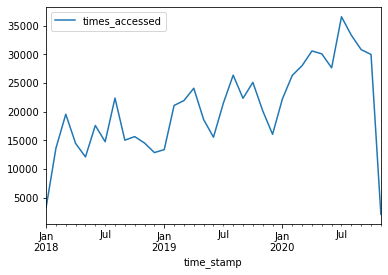

In [13]:
df[['times_accessed']].resample('m').sum().plot()

In [14]:
df.groupby(['times_accessed','cohort_id']).count()

page  user_id     ip  is_ds
times_accessed cohort_id                              
1              1.0         8884     8884   8884   8884
               2.0           93       93     93     93
               4.0            4        4      4      4
               5.0            1        1      1      1
               6.0           72       72     72     72
               7.0          495      495    495    495
               8.0         1712     1712   1712   1712
               9.0            5        5      5      5
               11.0         208      208    208    208
               12.0         302      302    302    302
               13.0        2733     2733   2733   2733
               14.0        9495     9495   9495   9495
               15.0         691      691    691    691
               16.0         743      743    743    743
               17.0        4925     4925   4925   4925
               18.0        2005     2005   2005   2005
               19.0        1165     1165   1165   1165
               21.0        7444     7444   7444   7444
               22.0       30328    30328  30328  30328
               23.0       28329    28329  28329  28329
               24.0       35624    35624  35624  35624
               25.0       25427    25427  25427  25427
               26.0       27637    27637  27637  27637
               27.0       20447    20447  20447  20447
               28.0       60315    60315  60315  60315
               29.0       37548    37548  37548  37548
               31.0       25253    25253  25253  25253
               32.0       28333    28333  28333  28333
               33.0       40168    40168  40168  40168
               34.0       25181    25181  25181  25181
               51.0       29688    29688  29688  29688
               52.0       27518    27518  27518  27518
               53.0       36047    36047  36047  36047
               55.0       20410    20411  20411  20411
               56.0       31670    31670  31670  31670
               57.0       32447    32447  32447  32447
               58.0       28354    28354  28354  28354
               59.0       22425    22425  22425  22425
               61.0       11774    11774  11774  11774
               62.0        8718     8718   8718   8718

In [198]:
df2 = df.groupby(['page', 'cohort_id'])['times_accessed'].sum().reset_index().sort_values('times_accessed', ascending = False)
df2.head()

,page,cohort_id,times_accessed
25,/,24.0,2098
41,/,59.0,2041
36,/,53.0,1962
33,/,34.0,1842
29,/,29.0,1756


In [16]:
df2.head(20)

,page,cohort_id,times_accessed
0,%20https://github.com/RaulCPena,55.0,1
1,",%20https://github.com/RaulCPena",55.0,1
2,.git,24.0,1
3,.gitignore,24.0,1
4,.well-known/assetlinks.json,58.0,2
5,/,1.0,622
6,/,2.0,17
7,/,4.0,1
8,/,5.0,1
9,/,6.0,4


In [204]:
# Dropping all request to the home page. drop toc, search
df2 = df2[df2.page != '/']
df2 = df2[df2.page != 'toc']
df2.head

<bound method NDFrame.head of                                                     page  cohort_id  \
6843                                        javascript-i       33.0   
6836                                        javascript-i       24.0   
6850                                        javascript-i       58.0   
5997                                          index.html       14.0   
6840                                        javascript-i       29.0   
...                                                  ...        ...   
4302                 content/php_ii/control-structures-i       21.0   
4305                 content/php_ii/control-structures-i       24.0   
4313   content/php_ii/control-structures-i/do-while.html       18.0   
4315   content/php_ii/control-structures-i/do-while.html       23.0   
10425                                           wp-login       22.0   

       times_accessed  
6843              977  
6836              884  
6850              884  
5997              877

In [18]:
df2 = df2[df2.page != 'toc']

In [19]:
df2.head()

,page,cohort_id,times_accessed
0,%20https://github.com/RaulCPena,55.0,1
1,",%20https://github.com/RaulCPena",55.0,1
2,.git,24.0,1
3,.gitignore,24.0,1
4,.well-known/assetlinks.json,58.0,2


In [20]:
df2 = df2.sort_values(by= 'cohort_id', ascending = False)
df2.head()


,page,cohort_id,times_accessed
7094,java-i,62.0,22
3342,assets/js/pdfmake.min.js.map,62.0,4
10629,slides/introduction_to_java,62.0,1
6622,html-css/css-i/flexbox/flexbox-in-practice,62.0,159
8104,javascript-i/bom-and-dom/dom-events,62.0,10


In [21]:
df2.head()

,page,cohort_id,times_accessed
7094,java-i,62.0,22
3342,assets/js/pdfmake.min.js.map,62.0,4
10629,slides/introduction_to_java,62.0,1
6622,html-css/css-i/flexbox/flexbox-in-practice,62.0,159
8104,javascript-i/bom-and-dom/dom-events,62.0,10


In [22]:
df.describe()

,user_id,cohort_id,times_accessed
count,719459.000000,674619.000000,719459.0
mean,392.945478,37.173660,1.0
std,211.655544,14.971385,0.0
min,1.000000,1.000000,1.0
25%,230.000000,26.000000,1.0
50%,417.000000,32.000000,1.0
75%,568.000000,53.000000,1.0
max,787.000000,62.000000,1.0


In [23]:
df2.describe()

,cohort_id,times_accessed
count,11706.000000,11706.000000
mean,30.417991,53.402614
std,16.546420,104.148774
min,1.000000,1.000000
25%,19.000000,2.000000
50%,28.000000,6.000000
75%,34.000000,49.000000
max,62.000000,1376.000000


In [24]:
# Creating pages accessed data frame to see how many times ds students hit different pages

# sorting by the times accessed from highest to lowest
ds_pgs_accessed_df = df2.sort_values(by = 'times_accessed', ascending=False)

# adding mask to destinguish between ds and web_dev students
ds_pgs_accessed_df['is_ds'] = ds_pgs_accessed_df.cohort_id.isin([30,34,55,59])

# Selecting only ds students
ds_pgs_accessed_df = ds_pgs_accessed_df[ds_pgs_accessed_df.is_ds == True]

ds_pgs_accessed_df.head(10)

,page,cohort_id,times_accessed,is_ds
3470,classification/overview,59.0,759,True
180,1-fundamentals/modern-data-scientist.jpg,34.0,626,True
157,1-fundamentals/AI-ML-DL-timeline.jpg,34.0,624,True
80,1-fundamentals/1.1-intro-to-data-science,34.0,615,True
1226,6-regression/1-overview,55.0,595,True
3491,classification/scale_features_or_not.svg,59.0,590,True
10355,search/search_index.json,34.0,551,True
1225,6-regression/1-overview,34.0,521,True
11342,sql/mysql-overview,59.0,513,True
10359,search/search_index.json,55.0,480,True


## **Which lesson appears to attract the most traffic consistently across cohorts (per program)?**
For data science, the top five pages viewed across any cohort were 
1. classification/overview - cohort 59 with 759 views
2. 1-fundamentals/modern-data-scientist.jpg - cohort 34 with 626 views
3. 1-fundamentals/AI-ML-DL-timeline.jpg	- cohort 34 with 624 views
4. 1-fundamentals/1.1-intro-to-data-science	- cohort 34 with 615 views
5. 6-regression/1-overview - cohort 55 with 595 views

**ADA 30**
1. No data

**Bayes 34**
1. 1-fundamentals/modern-data-scientist.jpg - views 626
2. 1-fundamentals/AI-ML-DL-timeline.jpg - views 624
3. 1-fundamentals/1.1-intro-to-data-science - views 615

**Curie 55**
1. 6-regression/1-overview - views 595
1. 1-fundamentals/modern-data-scientist.jpg - views 467
2. 1-fundamentals/AI-ML-DL-timeline.jpg - views 465

**Darden 59**
1. classification/overview - views 759
2. classification/scale_features_or_not.svg - views 590
3. sql/mysql-overview - views 513

In [25]:
# Just ADA. No data showing in ada
#df2.sort_values(by = 'times_accessed', ascending=False)
df2.cohort_id.value_counts()

28.0    1319
22.0     529
14.0     476
34.0     449
25.0     415
55.0     397
23.0     397
17.0     381
24.0     375
61.0     371
31.0     364
59.0     349
13.0     341
1.0      340
32.0     325
18.0     315
21.0     310
29.0     307
27.0     304
33.0     295
57.0     287
26.0     278
19.0     278
8.0      276
51.0     267
58.0     266
52.0     261
56.0     258
53.0     249
15.0     230
62.0     156
16.0     132
7.0      128
12.0     115
11.0      74
6.0       44
2.0       42
4.0        3
9.0        3
Name: cohort_id, dtype: int64

In [26]:
df2 = df2[df2.page != 'search/search_index.json']

In [27]:
# Creating pages accessed data frame to see how many times ds students hit different pages

# sorting by the times accessed from highest to lowest
wdev_pgs_accessed_df = df2.sort_values(by = 'times_accessed', ascending=False)

# adding mask to destinguish between ds and web_dev students
wdev_pgs_accessed_df['is_ds'] = wdev_pgs_accessed_df.cohort_id.isin([30,34,55,59])

# Selecting only ds students
wdev_pgs_accessed_df = wdev_pgs_accessed_df[wdev_pgs_accessed_df.is_ds == False]

# Going to drop search/search_index.json as it adds no value in regards to the curriculum and
# dropping staff cohort

wdev_pgs_accessed_df = wdev_pgs_accessed_df[wdev_pgs_accessed_df.page != 'search/search_index.json']
wdev_pgs_accessed_df = wdev_pgs_accessed_df[wdev_pgs_accessed_df.cohort_id != 28]
wdev_pgs_accessed_df.head(25)

,page,cohort_id,times_accessed,is_ds
7892,javascript-i,33.0,977,False
7899,javascript-i,58.0,884,False
7884,javascript-i,24.0,884,False
7013,index.html,14.0,877,False
7889,javascript-i,29.0,868,False
7602,java-iii,24.0,770,False
7614,java-iii,53.0,767,False
7896,javascript-i,53.0,756,False
7295,java-ii,24.0,754,False
6466,html-css,33.0,753,False


## Which lesson appears to attract the most traffic consistently across cohorts (per program)? Cohort 28 is staff and makes up the majority of pages seen. Going to remove
For **WebDev**, the top five pages viewed per any cohort were 
1. javascript-i	 - cohort 33, 58, 24, & 29 with 869 - 977 views
2. index - cohort 14 with 877 views
3. java-iii	- cohort 24, 53, 29 with 742 - 770 views
4. html-css	- cohort 33 with 753 views and 56 with 708 views
5. spring - cohort 22 with 707 views and 24 & 29 with 650 views

In [28]:
df2.groupby(['cohort_id','page'])['times_accessed'].agg(['min', 'mean','max'])

min  mean  max
cohort_id page                                       
1.0       0_Classification_Algorithms    1     1    1
          2.0_Intro_Stats                1     1    1
          5.0_Intro_Regression           2     2    2
          7.0_Intro_Clustering           2     2    2
          8.0_Intro_Module               1     1    1
...                                    ...   ...  ...
62.0      web-design                     1     1    1
          web-design/ui/color            1     1    1
          web-design/ui/typography       1     1    1
          web-design/ux/layout           1     1    1
          web-design/ux/purpose          1     1    1

[11672 rows x 3 columns]

### Takeaway: Cohort 28 had the most hits at 4633, followed by cohort 24, then darden cohort 59. 

In [29]:
my_ip = '162.197.239.66'
df[df.ip == my_ip]

,page,user_id,cohort_id,ip,is_ds,times_accessed
time_stamp,,,,,,
2020-07-13 14:49:30,/,695,59.0,162.197.239.66,True,1
2020-07-14 15:04:52,/,695,59.0,162.197.239.66,True,1
2020-07-14 15:10:04,1-fundamentals/1.1-intro-to-data-science,695,59.0,162.197.239.66,True,1
2020-07-14 15:10:04,1-fundamentals/AI-ML-DL-timeline.jpg,695,59.0,162.197.239.66,True,1
2020-07-14 15:10:04,1-fundamentals/modern-data-scientist.jpg,695,59.0,162.197.239.66,True,1
...,...,...,...,...,...,...
2020-10-29 06:37:30,regression/project,695,59.0,162.197.239.66,True,1
2020-10-29 06:43:35,regression/feature-engineering,695,59.0,162.197.239.66,True,1
2020-10-29 10:18:10,timeseries/explore,695,59.0,162.197.239.66,True,1


# Is there a cohort that referred to a lesson significantly more that other cohorts seemed to gloss over? 
- Going to compare the top five viewed cohort pages and compare to how all other cohorts viewed those pages

# Data Science

In [30]:
ds_pgs_accessed_df.head()

,page,cohort_id,times_accessed,is_ds
3470,classification/overview,59.0,759,True
180,1-fundamentals/modern-data-scientist.jpg,34.0,626,True
157,1-fundamentals/AI-ML-DL-timeline.jpg,34.0,624,True
80,1-fundamentals/1.1-intro-to-data-science,34.0,615,True
1226,6-regression/1-overview,55.0,595,True


In [31]:
ds_pgs_accessed_df[ds_pgs_accessed_df.page .isin(["classification/overview"])]

,page,cohort_id,times_accessed,is_ds
3470,classification/overview,59.0,759,True
3469,classification/overview,55.0,91,True
3468,classification/overview,34.0,10,True


### Our cohort looked at classification overview significantly more than all other cohorts.

In [32]:
ds_pgs_accessed_df[ds_pgs_accessed_df.page .isin(["1-fundamentals/modern-data-scientist.jpg"])]

,page,cohort_id,times_accessed,is_ds
180,1-fundamentals/modern-data-scientist.jpg,34.0,626,True
182,1-fundamentals/modern-data-scientist.jpg,59.0,470,True
181,1-fundamentals/modern-data-scientist.jpg,55.0,467,True


### 1-fundamentals/modern-data-scientist.jpg seemed to be evenly distributed 

In [33]:
ds_pgs_accessed_df[ds_pgs_accessed_df.page .isin(["1-fundamentals/AI-ML-DL-timeline.jpg"])]

,page,cohort_id,times_accessed,is_ds
157,1-fundamentals/AI-ML-DL-timeline.jpg,34.0,624,True
159,1-fundamentals/AI-ML-DL-timeline.jpg,59.0,470,True
158,1-fundamentals/AI-ML-DL-timeline.jpg,55.0,465,True


## 1-fundamentals/modern-data-scientist.jpg seemed to be evenly distributed

In [34]:
ds_pgs_accessed_df[ds_pgs_accessed_df.page .isin(["1-fundamentals/1.1-intro-to-data-science"])]

,page,cohort_id,times_accessed,is_ds
80,1-fundamentals/1.1-intro-to-data-science,34.0,615,True
81,1-fundamentals/1.1-intro-to-data-science,55.0,461,True
82,1-fundamentals/1.1-intro-to-data-science,59.0,460,True


## 1-fundamentals/1.1-intro-to-data-science seemed to be evenly distributed

In [35]:
ds_pgs_accessed_df[ds_pgs_accessed_df.page .isin(["6-regression/1-overview"])]

,page,cohort_id,times_accessed,is_ds
1226,6-regression/1-overview,55.0,595,True
1225,6-regression/1-overview,34.0,521,True
1227,6-regression/1-overview,59.0,7,True


### 6-regression/1-overview Darden barely accessed the regression overview unlike Bayes or Curie

In [36]:
ds_pgs_accessed_df[ds_pgs_accessed_df.page .isin(["sql/mysql-overview"])]


,page,cohort_id,times_accessed,is_ds
11342,sql/mysql-overview,59.0,513,True
11341,sql/mysql-overview,55.0,99,True
11340,sql/mysql-overview,34.0,3,True


### Darden looked at sql/mysql-overview	significantly more than Bayes and Curie

# Web Dev

In [37]:
wdev_pgs_accessed_df.head(25)

,page,cohort_id,times_accessed,is_ds
7892,javascript-i,33.0,977,False
7899,javascript-i,58.0,884,False
7884,javascript-i,24.0,884,False
7013,index.html,14.0,877,False
7889,javascript-i,29.0,868,False
7602,java-iii,24.0,770,False
7614,java-iii,53.0,767,False
7896,javascript-i,53.0,756,False
7295,java-ii,24.0,754,False
6466,html-css,33.0,753,False


In [38]:
wdev_pgs_accessed_df[wdev_pgs_accessed_df.page .isin(["javascript-i"])]

,page,cohort_id,times_accessed,is_ds
7892,javascript-i,33.0,977,False
7899,javascript-i,58.0,884,False
7884,javascript-i,24.0,884,False
7889,javascript-i,29.0,868,False
7896,javascript-i,53.0,756,False
7886,javascript-i,26.0,718,False
7894,javascript-i,51.0,696,False
7898,javascript-i,57.0,694,False
7891,javascript-i,32.0,686,False
7897,javascript-i,56.0,610,False


### javascript-i was significantly looked at less in cohorts 12, 2, 6, 15, 19, 11, 7, 13, 16, 8, 17, & 18 with a range of 1 - 128 views as opposed to cohort 33 with 977 views.

In [39]:
wdev_pgs_accessed_df[wdev_pgs_accessed_df.page .isin(["index.html"])]

,page,cohort_id,times_accessed,is_ds
7013,index.html,14.0,877,False
7012,index.html,13.0,84,False
7015,index.html,16.0,63,False
7017,index.html,18.0,35,False
7016,index.html,17.0,28,False
7011,index.html,12.0,8,False
7018,index.html,19.0,6,False
7010,index.html,11.0,6,False
7008,index.html,1.0,1,False
7019,index.html,25.0,1,False


### Cohort 14 looked at the index.html significantly more than any other cohort. Only 13 total cohorts looked at the index with cohort 13 closest at 84 views.

In [40]:
wdev_pgs_accessed_df[wdev_pgs_accessed_df.page .isin(["java-iii"])]

,page,cohort_id,times_accessed,is_ds
7602,java-iii,24.0,770,False
7614,java-iii,53.0,767,False
7607,java-iii,29.0,742,False
7600,java-iii,22.0,712,False
7610,java-iii,33.0,674,False
7617,java-iii,58.0,651,False
7616,java-iii,57.0,620,False
7615,java-iii,56.0,616,False
7612,java-iii,51.0,517,False
7604,java-iii,26.0,495,False


### java-iii was looked at significantly more in cohorts 22, 29, 24 and 53 with a range of 712 - 770. Cohorts 17, 15, 13, 62, 11, 19, 6, 12 had a range of views of 1-25.

In [41]:
wdev_pgs_accessed_df[wdev_pgs_accessed_df.page .isin(["html-css"])]

,page,cohort_id,times_accessed,is_ds
6466,html-css,33.0,753,False
6471,html-css,56.0,708,False
6463,html-css,29.0,649,False
6468,html-css,51.0,609,False
6460,html-css,26.0,587,False
6470,html-css,53.0,578,False
6457,html-css,23.0,555,False
6458,html-css,24.0,528,False
6472,html-css,57.0,472,False
6465,html-css,32.0,425,False


### html-css was looked at significantly more with cohorts 29, 33, & 56. Cohorts 7, 8, 11, 19, 13, 16, 12, 15, 2, & 6 barely looked at this page with views ranging from 1-21.

In [42]:
wdev_pgs_accessed_df[wdev_pgs_accessed_df.page .isin(["spring"])]

,page,cohort_id,times_accessed,is_ds
10857,spring,22.0,707,False
10864,spring,29.0,650,False
10859,spring,24.0,650,False
10871,spring,53.0,616,False
10872,spring,56.0,572,False
10867,spring,33.0,546,False
10869,spring,51.0,512,False
10865,spring,31.0,485,False
10873,spring,57.0,465,False
10861,spring,26.0,453,False


### spring was looked at significantly more with cohorts 22, 29, 24, & 53. Cohorts 61, 17, 15, 62, 19, 11, 13, 7, & 6 barely looked at this page with views ranging from 1-29.

# 3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students? 

In [43]:
ds_cohort_list = ds_pgs_accessed_df.cohort_id.unique()
ds_cohort_list

array([59., 34., 55.])

In [44]:
# Loop for getting the top pages accessed for each cohort

top_ds = []
for c in ds_cohort_list:
    top_ds.append(ds_pgs_accessed_df[ds_pgs_accessed_df.cohort_id == c].head())
top_ds[1]

,page,cohort_id,times_accessed,is_ds
180,1-fundamentals/modern-data-scientist.jpg,34.0,626,True
157,1-fundamentals/AI-ML-DL-timeline.jpg,34.0,624,True
80,1-fundamentals/1.1-intro-to-data-science,34.0,615,True
10355,search/search_index.json,34.0,551,True
1225,6-regression/1-overview,34.0,521,True


In [45]:
#darden.groupby(['time_stamp', 'page'])['times_accessed','user_id'].agg(['min','mean','max'])

In [46]:
# Getting rid of pages that don't matter, cohort 28 that is staff. Creating a start and end date
df = df[df.page != 'search/search_index.json']
df = df[df.cohort_id != 28]
df.groupby(['user_id','cohort_id']).agg('sum').sort_values(by='times_accessed', ascending = True).head(4)

,,is_ds,times_accessed
user_id,cohort_id,,
787,55.0,1,1
619,57.0,0,1
593,14.0,0,1
163,19.0,0,1


### Yes there are students who are rarely accessing the curriculum. Example, in cohorts 55 (user 787), 57 (user 619), 14 (user 593) and 19 (user 163) all accessed the curriculum one time. User 787 looked only at the appendix/interview_questions_students. Users 619 & 163 looked only at the home page. User 593 looked at the index once. So it appears that one person was interested in interview questions, 2 went to the home page and stopped looking, and one went to the index.

In [47]:
df[df.user_id == 787]

,page,user_id,cohort_id,ip,is_ds,times_accessed
time_stamp,,,,,,
2020-10-29 22:08:03,appendix/interview_questions_students,787,55.0,99.126.113.140,True,1


In [48]:
df[df.user_id == 619]

,page,user_id,cohort_id,ip,is_ds,times_accessed
time_stamp,,,,,,
2020-03-23 14:10:17,/,619,57.0,97.105.19.58,False,1


In [49]:
df[df.user_id == 593]

,page,user_id,cohort_id,ip,is_ds,times_accessed
time_stamp,,,,,,
2020-02-17 11:45:21,index.html,593,14.0,167.24.104.150,False,1


In [50]:
df[df.user_id == 163]

,page,user_id,cohort_id,ip,is_ds,times_accessed
time_stamp,,,,,,
2018-03-29 22:40:57,/,163,19.0,192.171.117.234,False,1


In [51]:
# Bringing in the csv file zack had on slack
cohort_df = pd.read_csv('cohorts.csv')
cohort_df.head(1)

,cohort_id,name,start_date,end_date,program_id
0,1,Arches,2014-02-04,2014-04-22,1


In [52]:
df['date'] = df.index
df.head()

,page,user_id,cohort_id,ip,is_ds,times_accessed,date
time_stamp,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,False,1,2018-01-26 09:55:03
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:02
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:05
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:06
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,False,1,2018-01-26 09:56:24


In [53]:
# Merging the original data frame with zacks
df = df.merge(cohort_df, on ='cohort_id', how = 'left')

In [54]:
df.head()

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id
0,/,1,8.0,97.105.19.61,False,1,2018-01-26 09:55:03,Hampton,2015-09-22,2016-02-06,1.0
1,java-ii,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:02,Hampton,2015-09-22,2016-02-06,1.0
2,java-ii/object-oriented-programming,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:05,Hampton,2015-09-22,2016-02-06,1.0
3,slides/object_oriented_programming,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:06,Hampton,2015-09-22,2016-02-06,1.0
4,javascript-i/conditionals,2,22.0,97.105.19.61,False,1,2018-01-26 09:56:24,Teddy,2018-01-08,2018-05-17,2.0


In [55]:
df.index = df.date

In [56]:
df.head()

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id
date,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,False,1,2018-01-26 09:55:03,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:02,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:05,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:06,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,False,1,2018-01-26 09:56:24,Teddy,2018-01-08,2018-05-17,2.0


In [57]:
darden = df[df.cohort_id == 59]
darden.head()

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id
date,,,,,,,,,,,
2020-07-13 14:34:44,/,678,59.0,76.201.20.193,True,1,2020-07-13 14:34:44,Darden,2020-07-13,2021-01-12,3.0
2020-07-13 14:37:22,/,679,59.0,24.28.146.155,True,1,2020-07-13 14:37:22,Darden,2020-07-13,2021-01-12,3.0
2020-07-13 14:38:28,/,680,59.0,136.50.56.155,True,1,2020-07-13 14:38:28,Darden,2020-07-13,2021-01-12,3.0
2020-07-13 14:39:21,13-advanced-topics/1-tidy-data,679,59.0,24.28.146.155,True,1,2020-07-13 14:39:21,Darden,2020-07-13,2021-01-12,3.0
2020-07-13 14:39:36,1-fundamentals/1.1-intro-to-data-science,679,59.0,24.28.146.155,True,1,2020-07-13 14:39:36,Darden,2020-07-13,2021-01-12,3.0


# 4. . Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses? Any odd user-agents? 

In [58]:
df.groupby(['user_id', 'page', 'cohort_id'])[['times_accessed']].agg('sum')

times_accessed
user_id page                                  cohort_id                
1       /                                     8.0                   202
        0_Classification_Algorithms           8.0                     1
        5.0_Intro_Regression                  8.0                     2
        Dataset_Challenge                     8.0                     1
        Module_6_Classification               8.0                     1
...                                                                 ...
786     java-i/methods                        56.0                    1
        java-i/syntax-types-and-variables     56.0                    1
        java-ii                               56.0                    1
        java-ii/object-oriented-programming   56.0                    1
787     appendix/interview_questions_students 55.0                    1

[83210 rows x 1 columns]

In [59]:
# Creating pages accessed data frame to see how many times ds students hit different pages

# sorting by the times accessed from highest to lowest
ds_pgs_accessed_df = df.sort_values(by = 'times_accessed', ascending=False)

# adding mask to destinguish between ds and web_dev students
ds_pgs_accessed_df['is_ds'] = ds_pgs_accessed_df.cohort_id.isin([30,34,55,59])

# Selecting only ds students
ds_pgs_accessed_df = ds_pgs_accessed_df[ds_pgs_accessed_df.is_ds == True]

ds_pgs_accessed_df.head(10)

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id
date,,,,,,,,,,,
2020-02-24 09:51:59,4-python/3-data-types-and-variables,581,55.0,97.105.19.58,True,1,2020-02-24 09:51:59,Curie,2020-02-03,2020-07-07,3.0
2020-02-24 10:15:53,4-python/5-functions,589,55.0,97.105.19.58,True,1,2020-02-24 10:15:53,Curie,2020-02-03,2020-07-07,3.0
2020-02-24 10:03:15,4-python/5-functions,580,55.0,97.105.19.58,True,1,2020-02-24 10:03:15,Curie,2020-02-03,2020-07-07,3.0
2020-02-24 10:04:13,4-python/5-functions,581,55.0,97.105.19.58,True,1,2020-02-24 10:04:13,Curie,2020-02-03,2020-07-07,3.0
2020-02-24 10:06:20,4-python/5-functions,480,34.0,97.105.19.58,True,1,2020-02-24 10:06:20,Bayes,2019-08-19,2020-01-30,3.0
2020-02-24 09:45:10,4-python/3-data-types-and-variables,582,55.0,97.105.19.58,True,1,2020-02-24 09:45:10,Curie,2020-02-03,2020-07-07,3.0
2020-02-24 09:42:27,4-python/5-functions,590,55.0,97.105.19.58,True,1,2020-02-24 09:42:27,Curie,2020-02-03,2020-07-07,3.0
2020-02-24 09:44:30,4-python/project,582,55.0,97.105.19.58,True,1,2020-02-24 09:44:30,Curie,2020-02-03,2020-07-07,3.0
2020-02-24 09:45:00,4-python/5-functions,582,55.0,97.105.19.58,True,1,2020-02-24 09:45:00,Curie,2020-02-03,2020-07-07,3.0


In [60]:
ds_ip_list = ds_pgs_accessed_df.ip.unique()
ds_ip_list

array(['97.105.19.58', '65.43.118.72', '174.207.0.84', '99.158.246.101',
       '192.171.117.210', '72.191.48.117', '173.149.245.229',
       '70.123.228.86', '107.132.82.186', '75.1.166.163', '12.97.187.252',
       '69.231.92.35', '166.251.106.121', '72.190.187.173',
       '72.190.169.29', '70.121.160.151', '172.124.64.127',
       '173.149.239.160', '76.185.242.211', '99.126.113.140',
       '70.117.71.59', '70.117.30.148', '12.5.63.210', '107.77.217.156',
       '136.50.49.145', '70.94.160.147', '24.26.249.215', '72.177.240.51',
       '99.62.54.30', '166.251.101.225', '173.149.224.202',
       '64.250.9.181', '70.94.164.83', '67.10.165.185', '173.127.59.159',
       '166.251.112.197', '166.247.59.41', '12.132.197.125',
       '166.251.112.118', '104.5.217.57', '174.207.14.170',
       '71.143.84.242', '107.77.217.210', '107.77.221.22',
       '174.246.197.16', '166.251.101.164', '172.58.107.143',
       '75.1.34.153', '107.77.217.94', '173.127.123.225',
       '173.149.192.220', 

In [61]:
y = darden.groupby(['user_id'])['times_accessed'].sum()
darden_userid_list = darden.user_id.unique()
darden_userid_list

array([678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690,
       691, 692, 693, 694, 695, 268, 696, 697, 698, 699, 739, 780, 781,
       783, 785])

<AxesSubplot:xlabel='user_id'>

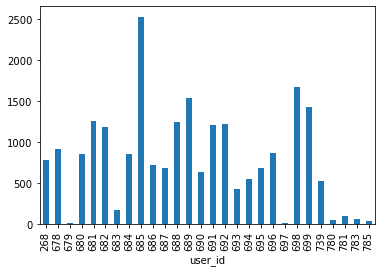

In [62]:
darden.groupby(['user_id'])['times_accessed'].sum().plot(kind='bar')

In [63]:
curie = df[df.cohort_id == 55]

In [64]:
df.head()

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id
date,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,False,1,2018-01-26 09:55:03,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:02,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:05,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:06,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,False,1,2018-01-26 09:56:24,Teddy,2018-01-08,2018-05-17,2.0


<AxesSubplot:xlabel='user_id'>

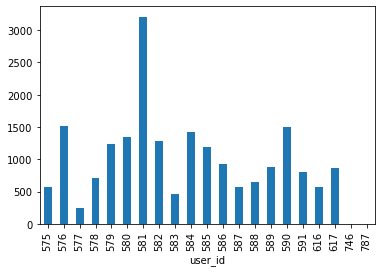

In [65]:
curie.groupby(['user_id'])['times_accessed'].sum().plot(kind='bar')

In [66]:
curie[curie.user_id == 787]

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id
date,,,,,,,,,,,
2020-10-29 22:08:03,appendix/interview_questions_students,787,55.0,99.126.113.140,True,1,2020-10-29 22:08:03,Curie,2020-02-03,2020-07-07,3.0


In [67]:
bayes = df[df.cohort_id == 34]

<AxesSubplot:xlabel='user_id'>

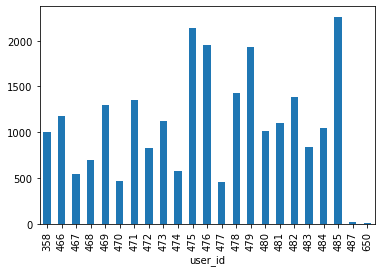

In [68]:
bayes.groupby(['user_id'])['times_accessed'].sum().plot(kind='bar')

In [69]:
# User looked strickly at appendix
bayes[bayes.user_id == 487]

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id
date,,,,,,,,,,,
2019-08-30 12:01:29,/,487,34.0,97.105.19.58,True,1,2019-08-30 12:01:29,Bayes,2019-08-19,2020-01-30,3.0
2019-08-30 12:02:11,appendix/cli/1-intro,487,34.0,97.105.19.58,True,1,2019-08-30 12:02:11,Bayes,2019-08-19,2020-01-30,3.0
2019-08-30 12:11:10,appendix/cli/2-listing-files,487,34.0,97.105.19.58,True,1,2019-08-30 12:11:10,Bayes,2019-08-19,2020-01-30,3.0
2019-08-30 13:37:40,appendix/cli/0-overview,487,34.0,97.105.19.58,True,1,2019-08-30 13:37:40,Bayes,2019-08-19,2020-01-30,3.0
2019-08-30 13:37:58,appendix/cli-git-overview,487,34.0,97.105.19.58,True,1,2019-08-30 13:37:58,Bayes,2019-08-19,2020-01-30,3.0
2019-08-30 14:12:22,appendix/cli/3-file-paths,487,34.0,97.105.19.58,True,1,2019-08-30 14:12:22,Bayes,2019-08-19,2020-01-30,3.0
2019-08-30 14:19:45,appendix/cli/4-navigating-the-filesystem,487,34.0,97.105.19.58,True,1,2019-08-30 14:19:45,Bayes,2019-08-19,2020-01-30,3.0
2019-08-30 14:32:22,appendix/cli/5-creating-files-and-directories,487,34.0,97.105.19.58,True,1,2019-08-30 14:32:22,Bayes,2019-08-19,2020-01-30,3.0
2019-08-30 14:38:57,appendix/cli/4-navigating-the-filesystem,487,34.0,97.105.19.58,True,1,2019-08-30 14:38:57,Bayes,2019-08-19,2020-01-30,3.0


In [70]:
bayes[bayes.user_id == 650]

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id
date,,,,,,,,,,,
2020-05-07 10:35:25,/,650,34.0,70.123.225.30,True,1,2020-05-07 10:35:25,Bayes,2019-08-19,2020-01-30,3.0
2020-05-07 10:35:52,appendix/professional-development/virtual-meet...,650,34.0,70.123.225.30,True,1,2020-05-07 10:35:52,Bayes,2019-08-19,2020-01-30,3.0
2020-06-25 10:18:26,/,650,34.0,70.123.225.30,True,1,2020-06-25 10:18:26,Bayes,2019-08-19,2020-01-30,3.0
2020-06-25 10:19:01,appendix/cli-git-overview,650,34.0,70.123.225.30,True,1,2020-06-25 10:19:01,Bayes,2019-08-19,2020-01-30,3.0
2020-06-25 10:20:00,appendix/ds-environment-setup,650,34.0,70.123.225.30,True,1,2020-06-25 10:20:00,Bayes,2019-08-19,2020-01-30,3.0
2020-07-03 15:13:38,/,650,34.0,70.123.225.30,True,1,2020-07-03 15:13:38,Bayes,2019-08-19,2020-01-30,3.0
2020-07-03 15:15:21,11-nlp/3-acquire,650,34.0,70.123.225.30,True,1,2020-07-03 15:15:21,Bayes,2019-08-19,2020-01-30,3.0
2020-07-06 11:41:32,appendix/ds-environment-setup,650,34.0,70.123.225.30,True,1,2020-07-06 11:41:32,Bayes,2019-08-19,2020-01-30,3.0
2020-08-03 11:18:31,/,650,34.0,70.123.225.30,True,1,2020-08-03 11:18:31,Bayes,2019-08-19,2020-01-30,3.0


In [71]:
# Loop for getting the top ips accessed for each cohort

top_ds_ip = []
for x in ds_ip_list:
    top_ds_ip.append(ds_pgs_accessed_df[ds_pgs_accessed_df.ip == x].tail(20))
top_ds_ip[2]

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id
date,,,,,,,,,,,
2020-02-24 09:12:54,12-distributed-ml/2-environment-setup,476,34.0,174.207.0.84,True,1,2020-02-24 09:12:54,Bayes,2019-08-19,2020-01-30,3.0
2020-02-25 09:27:34,/,476,34.0,174.207.0.84,True,1,2020-02-25 09:27:34,Bayes,2019-08-19,2020-01-30,3.0


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 644847 entries, 2018-01-26 09:55:03 to 2020-11-02 16:48:47
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   page            644846 non-null  object        
 1   user_id         644847 non-null  int64         
 2   cohort_id       601798 non-null  float64       
 3   ip              644847 non-null  object        
 4   is_ds           644847 non-null  bool          
 5   times_accessed  644847 non-null  int64         
 6   date            644847 non-null  datetime64[ns]
 7   name            601798 non-null  object        
 8   start_date      601798 non-null  object        
 9   end_date        601798 non-null  object        
 10  program_id      601798 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 54.7+ MB


In [73]:
# Converting start and end date to date time
df.start_date = pd.to_datetime(df.start_date)
df.end_date = pd.to_datetime(df.end_date)

In [74]:
# Creating a column that creates a boolean mask for the date > start date
df['past_start_date'] = df.date > df.start_date

In [75]:
df.head()

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id,past_start_date
date,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,False,1,2018-01-26 09:55:03,Hampton,2015-09-22,2016-02-06,1.0,True
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:02,Hampton,2015-09-22,2016-02-06,1.0,True
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:05,Hampton,2015-09-22,2016-02-06,1.0,True
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:06,Hampton,2015-09-22,2016-02-06,1.0,True
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,False,1,2018-01-26 09:56:24,Teddy,2018-01-08,2018-05-17,2.0,True


In [76]:
# Creating a column that creates a boolean mask for users while enrolled
df['accessed_while_enrolled'] = ((df.date >= df.start_date) & (df.date <= df.end_date))

In [77]:
df.head()

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id,past_start_date,accessed_while_enrolled
date,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,False,1,2018-01-26 09:55:03,Hampton,2015-09-22,2016-02-06,1.0,True,False
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:02,Hampton,2015-09-22,2016-02-06,1.0,True,False
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:05,Hampton,2015-09-22,2016-02-06,1.0,True,False
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:06,Hampton,2015-09-22,2016-02-06,1.0,True,False
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,False,1,2018-01-26 09:56:24,Teddy,2018-01-08,2018-05-17,2.0,True,True


In [219]:
# Creating a mask for users accessing pages after graduation for all cohorts
after_grad = df[df.accessed_while_enrolled == False]
all_after_grad =  after_grad.groupby(['user_id']).count().sort_values(by='times_accessed', ascending = False)
all_after_grad

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id,past_start_date,accessed_while_enrolled
date,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,False,1,2018-01-26 09:55:03,Hampton,2015-09-22,2016-02-06,1.0,True,False
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:02,Hampton,2015-09-22,2016-02-06,1.0,True,False
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:05,Hampton,2015-09-22,2016-02-06,1.0,True,False
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:06,Hampton,2015-09-22,2016-02-06,1.0,True,False
2018-01-26 10:14:47,/,11,1.0,97.105.19.61,False,1,2018-01-26 10:14:47,Arches,2014-02-04,2014-04-22,1.0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-02 16:02:26,java-iii/servlets,717,NaN,136.50.18.157,False,1,2020-11-02 16:02:26,NaN,NaT,NaT,NaN,False,False
2020-11-02 16:03:50,appendix/further-reading/java/intellij-tomcat-...,727,NaN,70.94.165.107,False,1,2020-11-02 16:03:50,NaN,NaT,NaT,NaN,False,False
2020-11-02 16:04:18,java-iii/servlets,727,NaN,70.94.165.107,False,1,2020-11-02 16:04:18,NaN,NaT,NaT,NaN,False,False


In [223]:
user53 = after_grad[after_grad.user_id == 53]
user53.groupby(['page'])[['times_accessed']].count().sort_values(by='times_accessed',ascending =False)
user53.ip.value_counts()

97.105.19.58       4415
97.105.19.61       2307
67.10.174.56        710
67.10.161.55        651
192.171.117.210      36
173.175.82.174       23
173.174.212.111      18
98.6.52.59            2
107.77.221.110        2
72.128.136.219        1
75.54.33.178          1
Name: ip, dtype: int64

In [79]:
# Looking at currie
aft_grad_currie = after_grad[after_grad.cohort_id == 55]

In [80]:
# Grouping by user_id and summing the times accessed
aft_grad_currie = aft_grad_currie.groupby(['user_id']).sum().sort_values(by='times_accessed')

In [81]:
aft_grad_currie[['times_accessed']]

,times_accessed
user_id,
787,1
746,1
583,7
578,10
576,16
591,17
588,18
616,76
617,85


#### Users 581, 580 & 584 were chosen as they had the most times accessed post graduation. Looking specifically at user 581 as they had  

In [82]:
after_grad_581 = after_grad[((after_grad.user_id == 581))]

In [ ]:
after_grad_581.groupby(['page']).sum().sort_values(by='times_accessed', ascending = False).head(50)

#### Interesting find, could be some suspicious activity with the amount of access as opposed to the person next to them. This user accessed 919 pages after graduating compared to 190 who is the second highest value. There are interesting amounts of pages accessed having the same hits.

**Take a look if have time**
for x in webdev_list:
    df1 = df2_wd[df2_wd.cohort_id == x]
    if df1.date.between(df1.start_date, df1.end_date, inclusive = True).any():
        plt.figure(figsize = (10, 8))
        cohort_page_views = df1[df1.date.between(df1.start_date, df1.end_date, inclusive = True)].groupby('user_id').webpage.count()
        cohort_page_views.plot(kind = 'bar')
        low_cut = cohort_page_views.quantile(q = .1)
        plt.axhline(y = low_cut, xmin = 0, xmax = 1, linestyle = '--', label = "Botton 10%", color = "firebrick")
        plt.title(f"{x} Cohort")
        plt.xlabel("User")
        plt.legend()
        plt.show()
    else:
        print(f"No data found for {x} cohort.")

# Looking for suspect pages accessed in webdev

In [84]:
# Looking at fortuna
aft_grad_fortuna = after_grad[after_grad.cohort_id == 53]

In [85]:
# Grouping by user_id and summing the times accessed
aft_grad_fortuna = aft_grad_fortuna.groupby(['user_id']).sum().sort_values(by='times_accessed')

In [86]:
# Looking at times accessed
aft_grad_fortuna[['times_accessed']].tail()

,times_accessed
user_id,
120,118
547,188
570,361
566,466
555,546


#### Going to look at the last 2 users to see what exactly they were looking at

In [87]:
after_grad_555 = after_grad[(after_grad.user_id == 555)]

In [88]:
after_grad_555.groupby(['page']).sum().sort_values(by='times_accessed', ascending = False).head(50)

,user_id,cohort_id,is_ds,times_accessed,program_id,past_start_date,accessed_while_enrolled
page,,,,,,,
/,18315,1749.0,0,33,66.0,33,0
spring,15540,1484.0,0,28,56.0,28,0
spring/fundamentals/controllers,13875,1325.0,0,25,50.0,25,0
mysql,10545,1007.0,0,19,38.0,19,0
java-ii,9990,954.0,0,18,36.0,18,0
spring/fundamentals/views,9435,901.0,0,17,34.0,17,0
java-iii,9435,901.0,0,17,34.0,17,0
spring/setup,8325,795.0,0,15,30.0,15,0
java-i,7770,742.0,0,14,28.0,14,0


In [89]:
after_grad_555 = after_grad_555.groupby(['page']).sum().sort_values(by='times_accessed', ascending = False).head(50)
after_grad_555.describe()

,user_id,cohort_id,is_ds,times_accessed,program_id,past_start_date,accessed_while_enrolled
count,50.000000,50.000000,50.0,50.00000,50.000000,50.00000,50.0
mean,4528.800000,432.480000,0.0,8.16000,16.320000,8.16000,0.0
std,3774.799435,360.476342,0.0,6.80144,13.602881,6.80144,0.0
min,1665.000000,159.000000,0.0,3.00000,6.000000,3.00000,0.0
25%,2220.000000,212.000000,0.0,4.00000,8.000000,4.00000,0.0
50%,2775.000000,265.000000,0.0,5.00000,10.000000,5.00000,0.0
75%,5272.500000,503.500000,0.0,9.50000,19.000000,9.50000,0.0
max,18315.000000,1749.000000,0.0,33.00000,66.000000,33.00000,0.0


#### Nothing looks too bad here, moving on

In [90]:
after_grad_566 = after_grad[(after_grad.user_id == 566)]

In [91]:
uni_pgs_566 = after_grad_566.groupby(['page']).sum().sort_values(by='times_accessed', ascending = False).head(50)

In [92]:
print(f'The total number of Webdev unique pages: {len(after_grad_566.page.unique())}')
print(f'The total number of unique pages seen by user 556: {len(uni_pgs_566)}')

The total number of Webdev unique pages: 110
The total number of unique pages seen by user 556: 50


#### Overall alot of pages looked at over half. Could be normal usage?

# Going to look at an older WebDev cohort

In [93]:
# Looking at kings
aft_grad_kings = after_grad[after_grad.cohort_id == 13]

In [94]:
# Grouping by user_id and summing the times accessed
aft_grad_kings = aft_grad_kings.groupby(['user_id']).sum().sort_values(by='times_accessed')

In [95]:
# Looking at times accessed
aft_grad_kings[['times_accessed']].tail()

,times_accessed
user_id,
167,166
93,168
50,280
51,487
68,1351


#### user 68 looks suspicious with 1351 times pages accessed after graduating compared to user 51 with 487 pages accessed.

In [96]:
after_grad_68 = after_grad[(after_grad.user_id == 68)]
uni_pgs_68 = after_grad_68.groupby(['page']).sum().sort_values(by='times_accessed', ascending = False).head(50)

In [97]:
print(f'The total number of unique pages seen by user 68: {len(uni_pgs_68)}')

The total number of unique pages seen by user 68: 50


#### Shows the same number of pages looked at as the user 556. Could be normal traffic.

In [107]:
# Creating a mask for users accessing pages after graduation

web_dev_stats = after_grad.groupby(['page']).sum().sort_values(by='times_accessed', ascending = False)
web_dev_stats

,user_id,cohort_id,is_ds,times_accessed,program_id,past_start_date,accessed_while_enrolled
page,,,,,,,
/,3741351,209080.0,746,11415,13872.0,7367,0
javascript-i,1023510,65533.0,0,3180,4346.0,2541,0
spring,732674,69047.0,0,2668,4415.0,2458,0
html-css,755790,51001.0,0,2377,3362.0,1952,0
java-ii,726620,50796.0,0,2255,3228.0,1841,0
...,...,...,...,...,...,...,...
6-regression/least-angle-regression,471,34.0,1,1,3.0,1,0
fundamentals/controllers,33,21.0,0,1,2.0,1,0
capstone/54,271,26.0,0,1,2.0,1,0


# Want to look into top usage users

In [109]:
# Looking at only web dev students that looked at curriculum after graduating
after_grad = df[df.accessed_while_enrolled == False]
after_grad = df[df.is_ds == False]
after_grad.head(1)

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id,past_start_date,accessed_while_enrolled
date,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,False,1,2018-01-26 09:55:03,Hampton,2015-09-22,2016-02-06,1.0,True,False


In [178]:
after_grad_stats = after_grad.groupby(['user_id'])[['times_accessed']].count()
after_grad_stats.sort_values(by = 'times_accessed', ascending = False).head()

,times_accessed
user_id,
53,8166
344,5366
570,4312
64,3802
555,3571


#### Users 53, 344, 570, 64 and 555 have the most pages viewed post graduating. User 53 has the most views and has 2800 more views than user 344 who is the second highest. Might want to look into these users more thouroughly to see if anything suspicious is going on

In [167]:
pd.set_option('display.max_rows', 500)
top_views_postgrad = after_grad[after_grad.user_id.isin([53,344,570,64])]
top_views_postgrad.groupby(['user_id','page'])[['times_accessed']].count()

times_accessed
user_id page                                                    
53      /                                                     35
        1-fundamentals/1.1-intro-to-data-science               1
        1-fundamentals/AI-ML-DL-timeline.jpg                   1
        1-fundamentals/modern-data-scientist.jpg               1
        1._Fundamentals                                        4
...                                                          ...
570     spring/fundamentals/views                             49
        spring/setup                                          49
        toc                                                  441
        web-design/intro                                       3
        web-design/ui/typography                               1

[935 rows x 1 columns]

In [170]:
print(len(wdev_pgs_accessed_df.page.unique()))
print(len(top_views_postgrad.page.unique()))

1777
383


# 5. At some point in the last year, ability for students and alumni to cross-access curriculum (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before? 

In [120]:
ds_pgs_accessed_df.head()

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id
date,,,,,,,,,,,
2020-02-24 09:51:59,4-python/3-data-types-and-variables,581,55.0,97.105.19.58,True,1,2020-02-24 09:51:59,Curie,2020-02-03,2020-07-07,3.0
2020-02-24 10:15:53,4-python/5-functions,589,55.0,97.105.19.58,True,1,2020-02-24 10:15:53,Curie,2020-02-03,2020-07-07,3.0
2020-02-24 10:03:15,4-python/5-functions,580,55.0,97.105.19.58,True,1,2020-02-24 10:03:15,Curie,2020-02-03,2020-07-07,3.0
2020-02-24 10:04:13,4-python/5-functions,581,55.0,97.105.19.58,True,1,2020-02-24 10:04:13,Curie,2020-02-03,2020-07-07,3.0
2020-02-24 10:06:20,4-python/5-functions,480,34.0,97.105.19.58,True,1,2020-02-24 10:06:20,Bayes,2019-08-19,2020-01-30,3.0


In [121]:
# Going to look for key words used in both ds and webdev to see if there was cross access occuring.
ds_check = ds_pgs_accessed_df.page.str.contains('java|spring|html-css')
ds_check.value_counts()

False    66619
True        66
Name: page, dtype: int64

In [123]:
# Have to deal with nans to run code below
ds_check.fillna(True, inplace =True)

<AxesSubplot:xlabel='date'>

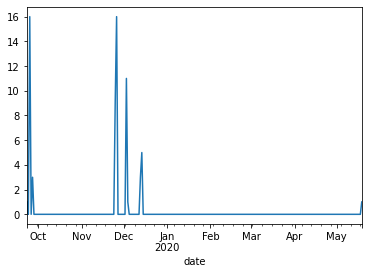

In [127]:
# Resample by day and plot to see when this was occuring.
log_ds_check = ds_pgs_accessed_df[ds_check]
log_ds_check.resample('D').page.count().plot()

#### There was some ds students looking at the curriculum last year in Sept, Nov and Dec. There does seem to be a hit in May of 2020.

## Web dev looking at ds curriculum

In [130]:
wdev_pgs_accessed_df = df[df.cohort_id != 28]
wdev_pgs_accessed_df = df[df.is_ds == False]
wdev_pgs_accessed_df.head()

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id,past_start_date,accessed_while_enrolled
date,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,False,1,2018-01-26 09:55:03,Hampton,2015-09-22,2016-02-06,1.0,True,False
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:02,Hampton,2015-09-22,2016-02-06,1.0,True,False
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:05,Hampton,2015-09-22,2016-02-06,1.0,True,False
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:06,Hampton,2015-09-22,2016-02-06,1.0,True,False
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,False,1,2018-01-26 09:56:24,Teddy,2018-01-08,2018-05-17,2.0,True,True


In [138]:
wd_check = wdev_pgs_accessed_df.page.str.contains('regression|intro-to-data-science|tableau|python|clustering|stats|classification|stats')
wd_check.value_counts()

False    577376
True        785
Name: page, dtype: int64

In [139]:
# Have to deal with nans to run code below
wd_check.fillna(True, inplace =True)

<AxesSubplot:xlabel='date'>

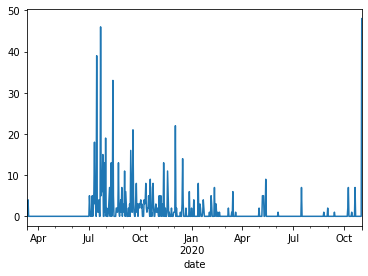

In [141]:
# Resample by day and plot to see when this was occuring. Have to deal with nans
log_wd_check = wdev_pgs_accessed_df[wd_check]
log_wd_check.resample('D').page.count().plot()

#### More webdev students access the ds curriculum. There were no hits before july 2019. Hits have slowed down since jan 2020. There is still wdev students accessing the the ds curriculum in 2020 up through oct. Not sure when access was shut down.

 # What topics are grads continuing to reference after graduation and into their jobs (for each program)? 

In [186]:
# Creating a mask for users accessing pages after graduation
after_grad = df[df.accessed_while_enrolled == False]
ds_after_grad = after_grad[after_grad.is_ds == True]
ds_after_grad.groupby(['page'])[['times_accessed']].count().sort_values(by = 'times_accessed', ascending = False).head(10)

,times_accessed
page,
/,746
1-fundamentals/modern-data-scientist.jpg,104
1-fundamentals/AI-ML-DL-timeline.jpg,103
1-fundamentals/1.1-intro-to-data-science,102
sql/mysql-overview,102
classification/overview,101
6-regression/1-overview,86
10-anomaly-detection/1-overview,69
10-anomaly-detection/AnomalyDetectionCartoon.jpeg,69


#### DS students are looking into 1-fundamentals the most with the top 3 views subsets of fundamentals. Then students are looking into sql, classification, regression, and anomaly detection.

## Webdev

In [187]:
# Creating a mask for users accessing pages after graduation
wd_after_grad = after_grad[after_grad.is_ds == False]
wd_after_grad.groupby(['page'])[['times_accessed']].count().sort_values(by = 'times_accessed', ascending = False).head(10)

,times_accessed
page,
/,10669
javascript-i,3180
spring,2668
html-css,2377
java-ii,2255
java-i,2222
java-iii,2059
javascript-ii,2007
toc,1881


#### Webdev students are looking at javascript-i, spring, html-css, java-ii, and java i the most. 

# 7. Which lessons are least accessed? 

In [194]:
ds = ds_after_grad.groupby(['page'])[['times_accessed']].count().sort_values(by = 'times_accessed', ascending = False)
ds

,times_accessed
page,
/,746
1-fundamentals/modern-data-scientist.jpg,104
1-fundamentals/AI-ML-DL-timeline.jpg,103
1-fundamentals/1.1-intro-to-data-science,102
sql/mysql-overview,102
classification/overview,101
6-regression/1-overview,86
10-anomaly-detection/1-overview,69
10-anomaly-detection/AnomalyDetectionCartoon.jpeg,69


#### While there is a lot of pages rarely accessed, tableau & various fundamentals lessons ie(/cli/creating-files-and-directories, /spreadsheets-overview)

In [231]:
wd = wd_after_grad.groupby(['page'])[['times_accessed']].count().sort_values(by = 'times_accessed', ascending = True)
wd

,times_accessed
page,
basic-statements,1
Regression_Python1,1
Regression%20_Project.md,1
Python_Libraries,1
MachineLearning_CheatSheet,1
...,...
java-ii,2255
html-css,2377
spring,2668


#### There are hundreds of pages looked at only 1 or 2 times. Difficult to pin point what exact topics are not being utilized post graduating.